# <img style="float: left; padding-right: 20px; width: 200px" src="attachment:logo.jpg">  IMT 2200 - Introducción a Ciencia de Datos
**Pontificia Universidad Católica de Chile**<br>
**Instituto de Ingeniería Matemática y Computacional**<br>
**Semestre 2023-2**<br>
**Profesor:** Rodrigo A. Carrasco <br>

# <h1><center>Tarea 03: EDA - Exploración de Datos</center></h1>

## Instrucciones

- Fecha de publicación: martes 17 de octubre de 2023.

- Fecha de límite de entrega: martes 31 de octubre de 2023, a las 23:59.

- Vía de entrega: Módulo de Tareas en Canvas.

- Esta Tarea debe desarrollarse de manera totalmente *individual*, de acuerdo a lo establecido en la sección de Integridad Académica en el programa del curso.

- La Tarea debe ser desarrollada en lenguaje de programación Python y la entrega en formato Jupyter Notebook.

- El desarrollo del Notebook debe ser claro y ordenado, incluyendo anotaciones (markdown) y comentarios que permitan seguir fácilmente el código y los pasos implementados a los correctores, y siguiendo buenas prácticas de programación. La presentación y claridad del notebook y código forman parte de la evaluación de la tarea.

- Las consultas y comentarios sobre la Tarea se deben hacer a traves del canal `Tarea 3` en el Foro del curso en Canvas.


## 1. Objetivos de la Tarea

### 1.1 Objetivo educacional

Esta Tarea tiene como objetivo que los estudiantes desarrollen la capacidad de manejar algunas de las librerías centrales para el desarrollo de Ciencia de Datos, con foco en la exploración de datos. 

En los ejercicios a desarrollar a continuación, usted deberá extraer y explorar datos en distintos formatos, de manera de responder las preguntas de cada parte de la Tarea.

### 1.2 Pregunta de ciencia de datos

Esta tarea tiene como objetivo crear y realizar un análisis descriptivo de una base de datos para el estudio de factores determinantes en el rendimiento escolar de los estudiantes de educación básica y media en Chile. En particular, se busca analizar la relación entre el rendimiento escolar, representado por el promedio general de notas de cada estudiante, y factores determinantes como el porcentaje de asistencia a clases, y la razón entre docentes y estudiantes de los establecimientos educacionales.

In [2]:
# algunas librerías que pueden ser de utilidad
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import seaborn as sns

# Librerías adicionales
import pyproj
import math
from rarfile import RarFile
from zipfile import ZipFile
from shutil import rmtree
from os import listdir, remove


## 2. Datos

Para este estudio, se utilizarán datos generados y publicados por el  Centro de Estudios del Ministerio de Educación de Chile: https://centroestudios.mineduc.cl/ <br>

El Centro de Estudios pone a disposición del público en general la plataforma Datos Abiertos para compartir información estadística en materia de educación, que incluye bases de datos de establecimientos educacionales, estudiantes y párvulos, docentes y asistentes de la educación, y sostenedores. Además, se entrega información georreferenciada.

Para el análisis planteado, se considerarán las siguientes fuentes de datos:

* **[BD1] Rendimiento académico por estudiante:** colección que agrupa datos para descagar información resumida del rendimiento desde el año 2002 al 2022.
https://datosabiertos.mineduc.cl/rendimiento-por-estudiante-2/

* **[BD2] Dotación docente por establecimiento:** datos de la dotación de docentes por colegio desde 2003 hasta este año 2023.
https://datosabiertos.mineduc.cl/resumen-de-docentes-por-establecimiento/

* **[BD3] Resumen de matrícula por establecimiento:** datos de cantidad de alumnos desde 2004 hasta 2022.
https://datosabiertos.mineduc.cl/resumen-de-matricula-por-establecimiento-educacional/

* **[BD4] Directorio de Establecimientos Educacionales:** Listado de establecimientos educacionales disponibles para cada año, desde 1992 a 2022. https://datosabiertos.mineduc.cl/directorio-de-establecimientos-educacionales/

* **[BD5]** Cartografía de comunas de Chile: capa vectorial disponible en la IDE Chile del Ministerio de Bienes Nacionales, https://www.ide.cl/.

In [3]:
%mkdir -p data/BD

In [4]:
db = {
      "Rendimiento-2022.rar": "https://datosabiertos.mineduc.cl/wp-content/uploads/2023/02/Rendimiento-2022.rar",
      "Resumen-docentes-EE-2022.rar": "https://datosabiertos.mineduc.cl/wp-content/uploads/2022/09/Resumen-docentes-EE-2022.rar",
      "Resumen-matricula-EE-2022-2.rar": "https://datosabiertos.mineduc.cl/wp-content/uploads/2022/10/Resumen-matricula-EE-2022-2.rar",
      "Directorio-oficial-EE-2022.rar": "https://datosabiertos.mineduc.cl/wp-content/uploads/2022/09/Directorio-oficial-EE-2022.rar"
      }
cod_ens = [110, 310, 410, 510, 610, 710, 810, 910]

df_bd = {}

## 3. Limpieza e Integración de Datos

Nuestro primer objetivo será generar un conjunto de datos limpio y consistente en una única tabla con valores promedio de NOTAS, ASISTENCIA, y RAZÓN DOCENTES/ESTUDIANTES para cada COMUNA del país. Para construir esta tabla, haga los pasos a continuación.

### 3.1 Acceso y revisión de bases (5 puntos)

Para cada conjuntos de datos, descargue los archivos correspondientes al año 2022 y léalos armando un dataframe para cada uno. Consulte la documentación asociada para identificar el contenido de cada uno.

Cada una de las bases de datos requiere un procesamiento previo al análisis. Aplique las operaciones necesarias para generar los conjuntos de datos limpios descritos en los siguientes puntos.

----

El siguiente codigo realiza la descarga de las bases de datos necesarias para el analisis educativo.

In [5]:
# Descarga de los archivos

for link in db:
    response = requests.get(db[link])
    with open(f"data/BD/{link}", "wb") as file:
        file.write(response.content)
        print(f"Downloaded {link}...")

resposte = requests.get("https://www.ide.cl/descargas/capas/mineduc/educacionales_2021.zip")
with open("data/BD/Educacionales.zip", "wb") as file:
    file.write(resposte.content)
    print("Downloaded Educacionales.zip...")

with open("data/BD/Comunas.zip", "wb") as file:
    resposte = requests.get("https://www.bcn.cl/obtienearchivo?id=repositorio/10221/10396/2/Comunas.zip")
    file.write(resposte.content)
    print("Downloaded Comunas.zip...")
       

Downloaded Rendimiento-2022.rar...
Downloaded Resumen-docentes-EE-2022.rar...
Downloaded Resumen-matricula-EE-2022-2.rar...
Downloaded Directorio-oficial-EE-2022.rar...
Downloaded Educacionales.zip...
Downloaded Comunas.zip...


In [6]:
# Descompresión de los archivos y lectura de los geodatos

for path in listdir("data/BD"):
    if path.endswith(".rar"):
        with RarFile(f"data/BD/{path}") as rf:
            file = list(filter(lambda x: x.endswith(".csv"), rf.namelist()))[0]
            df_bd[path] = pd.read_csv(rf.open(file), sep=";", low_memory=False)
            print(f"Read {path}...")

with ZipFile("data/BD/Educacionales.zip", 'r') as zip_ref:
    zip_ref.extractall("data/BD")
    remove("data/BD/Establecimientos Educacionales 2021/ER_UBICACIαN_EE_ESCOLAR_PUBL.pdf")
    with ZipFile("data/BD/GeoEducacionales.zip", "w") as zf:
        for file in listdir("data/BD/Establecimientos Educacionales 2021"):
            zf.write(f"data/BD/Establecimientos Educacionales 2021/{file}", arcname=file)
            print(f"Compressed {file}...")

remove("data/BD/Educacionales.zip")
rmtree("data/BD/Establecimientos Educacionales 2021")


Read Rendimiento-2022.rar...
Read Resumen-docentes-EE-2022.rar...
Read Resumen-matricula-EE-2022-2.rar...
Read Directorio-oficial-EE-2022.rar...
Compressed Establecimientos_Educacionales_2021.cpg...
Compressed Establecimientos_Educacionales_2021.dbf...
Compressed Establecimientos_Educacionales_2021.prj...
Compressed Establecimientos_Educacionales_2021.sbn...
Compressed Establecimientos_Educacionales_2021.sbx...
Compressed Establecimientos_Educacionales_2021.shp...
Compressed Establecimientos_Educacionales_2021.shp.xml...
Compressed Establecimientos_Educacionales_2021.shx...


### 3.2 Primera base (10 puntos)

A partir de los datos descargados, genere una base de datos [BD1_clean] resumida con la siguiente estructura:

| | COD_COMUNA |	NIVEL |	EDAD_ALU |	PROM_GRAL |	ASISTENCIA| SIT_FINAL|
|--- | --- | --- | --- |--- | --- |---|
|0| 	15101| 	media |	15 |	6.4 |	97| P|
|1| 	15101| 	media |	14 |	5.1 |	91|P|
|2| 	15101| 	media |	16 |	4.8 |	85|P|
|3| 	15101| 	media |	14 |	5.2 |	89|P|
|...| 	...| 	... |	... |	... |	...|...|

Esta base de datos resumida debe cumplir las siguientes características:
* Los datos corresponden sólo a estudiantes niños y jóvenes, se descartan los datos de estudiantes adultos.
* `NIVEL`: es una variable categórica que indica el nivel de enseñanza agrupado al cual pertenece cada estudiante, cuyos valores pueden ser [*media_ch*, *media_tp*, *básica*], donde *media_ch* corresponde a la educación media científico-humanista, y *media_tp* a la educación media técnico-profesional.
* `SIT_FINAL`:  es una variable categórica que indica la situación final de promoción al cierre del año escolar. Se conservan sólo los datos correspondientes a la situación Promovido/Reprobado.
* `PROM_GRAL, EDAD_ALU y PROM_GRAL` tienen los tipos de datos adecuados para aplicarles operaciones numéricas. 
* `COD_COMUNA, NIVEL, y SITUACION` son variables categóricas.
* El dataset no tiene valores nulos.

In [7]:
# Lectura y filtrado del dataframe de rendimiento, ademas solo se consideran niños y jovenes

bd1_clean = df_bd["Rendimiento-2022.rar"]
bd1_clean = bd1_clean[["COD_COM_ALU", "COD_ENSE", "EDAD_ALU", "PROM_GRAL", "ASISTENCIA", "SIT_FIN"]]
bd1_clean = bd1_clean[bd1_clean["COD_ENSE"].isin(cod_ens)]


In [8]:
# Funcion para generar las variables categoricas en base a "COD_ENSE"

def replace_category(x):
    if x == 110:
        return "basica"
    elif x == 310:
        return "media_ch"
    elif x in cod_ens[2:]:
        return "media_tp"
    

In [9]:
# Se mapea la columna "COD_ENSE" y se pasa al tipo de dato categorico

bd1_clean["COD_ENSE"] = bd1_clean["COD_ENSE"].map(replace_category)
bd1_clean["COD_ENSE"] = bd1_clean["COD_ENSE"].astype("category")

In [10]:
bd1_clean = bd1_clean[bd1_clean["EDAD_ALU"] != " "].astype({"EDAD_ALU": "int8"})
bd1_clean["PROM_GRAL"] = bd1_clean["PROM_GRAL"].str.replace(",", ".").astype(float)
bd1_clean = bd1_clean[bd1_clean["PROM_GRAL"] != 0.0] # Eliminacion de promedios 0.0, ya que no son validos (270k registros borrados)
bd1_clean = bd1_clean[bd1_clean["SIT_FIN"] != " "]

In [11]:
# Como cambiar el nombre de las columnas
bd1_clean = bd1_clean.rename(columns={"COD_COM_ALU": "COD_COMUNA", "COD_ENSE": "NIVEL", "SIT_FIN": "SIT_FINAL"})

Dataframe con los datos de la base [BD1] limpios y resumidos:

In [12]:
bd1_clean

,COD_COMUNA,NIVEL,EDAD_ALU,PROM_GRAL,ASISTENCIA,SIT_FINAL
19,4102,media_tp,14,4.5,85,P
20,15101,media_tp,15,5.1,89,P
21,15101,media_tp,16,5.3,89,P
22,15101,media_tp,16,5.9,90,P
24,15101,media_tp,14,5.7,90,P
...,...,...,...,...,...,...
3405077,6101,media_ch,15,5.6,85,P
3405079,6304,media_ch,16,6.0,85,P
3405081,6105,media_ch,21,6.6,90,P
3405084,6310,media_ch,17,6.9,90,P


### 3.3 Agregando promedios (5 punto)

Genere un nuevo dataframe que contenga lo valores promedio de `PROM_GRAL` y de `ASISTENCIA` de los alumnos de cada comuna.

In [13]:
gb_com = bd1_clean.groupby("COD_COMUNA").agg({"PROM_GRAL": "mean", "ASISTENCIA": "mean"}).reset_index()
gb_com

,COD_COMUNA,PROM_GRAL,ASISTENCIA
0,1101,6.142810,88.252485
1,1107,6.022235,87.409101
2,1401,6.144645,90.592623
3,1402,6.198462,93.192308
4,1403,6.195930,87.703488
...,...,...,...
341,16301,6.062676,89.338822
342,16302,5.967651,88.342200
343,16303,6.097999,88.901568
344,16304,6.063725,88.881127


### 3.4 Extendiendo el DataFrame (5 puntos)

A partir de  **[BD2]** y **[BD3]**, genere un único dataframe **[BD2_3]** con la siguiente estructura:

| |ESTABLECIMIENTO |	COMUNA |	REGION |	DC_TOT |	MAT_TOTAL| 	RAZON_DOC_EST|
|---|---|---|---|---|---|---|
|0 |	LICEO POLITECNICO ARICA 	|15101 |	15 	|71 |	664| 	0.106928|
|1 |	PARVULARIO LAS ESPIGUITAS 	|15101 |	15 	|16 |	170| 	0.094118|
|2 |	ESC. PEDRO VICENTE GUTIERREZ TORRES| 	15101| 	15 |	28| 	470| 	0.059574|
|... |	...| 	...| 	... |	...| 	...| 	...|

La variable `RAZON_DOC_EST` se define como la razón entre docentes y estudiantes de cada establecimiento, calculada como
`RAZON_DOC_EST=DC_TOT/MAT_TOTAL`, donde `DC_TOT` es el total de docentes del establecimiento, y `MAT_TOT` es la matrícula total de alumnos.

Para ello, ud. debe:
* Unir las bases de datos mediante una columna común.
* Renombrar las columnas que sea necesario.
* Eliminar registros de establecimientos con matrícula igual a cero.
* Crear las nuevas columnas que se requiera.
* Eliminar columnas innecesarias.
* Eliminar registros con datos nulos.

In [14]:
df_bd["Resumen-docentes-EE-2022.rar"]

,AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,DC_SUP_SOST,HH_SUP_SOST,DC_SUBDIR,HH_SUBDIR,DC_PROF_ENC,HH_PROF_ENC,DC_EDUC_TRAD,HH_EDUC_TRAD,DC_TOT,HH_TOT
0,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,0,0,0,0,0,0,0,0,70,2314
1,2022,2,7,PARVULARIO LAS ESPIGUITAS,15,AYP,151,15101,ARICA,151,...,0,0,0,0,0,0,0,0,17,576
2,2022,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,AYP,151,15101,ARICA,151,...,0,0,0,0,0,0,0,0,28,1086
3,2022,4,3,LICEO OCTAVIO PALMA PEREZ,15,AYP,151,15101,ARICA,151,...,0,0,0,0,0,0,0,0,63,2537
4,2022,5,1,JOVINA NARANJO FERNANDEZ,15,AYP,151,15101,ARICA,151,...,0,0,0,0,0,0,0,0,66,2416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16584,2022,42079,4,COLEGIO DE ADULTOS SU SANTIDAD JUAN PABLO II,4,COQ,41,4102,COQUIMBO,41,...,0,0,0,0,0,0,0,0,0,0
16585,2022,42080,8,JARDIN INFANTIL Y SALA CUNA 15ALAS MONTESSORI,12,MAG,121,12101,PUNTA ARENAS,121,...,0,0,0,0,0,0,0,0,0,0
16586,2022,42081,6,ESCUELA HOSPITALARIA SANTA CRUZ,6,LGBO,63,6310,SANTA CRUZ,62,...,0,0,0,0,0,0,0,0,0,0
16587,2022,42082,4,ESCUELA DE LENGUAJE PASO A PASO,8,BBIO,81,8110,TALCAHUANO,83,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_bd["Resumen-matricula-EE-2022-2.rar"]

,AGNO,RBD,DGV_RBD,NOM_RBD,COD_DEPE,COD_DEPE2,RURAL_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,...,CUR_SIM_03,CUR_SIM_04,CUR_SIM_05,CUR_SIM_06,CUR_SIM_07,CUR_SIM_08,CUR_SIM_TOT,CUR_COMB_01,CUR_COMB_02,CUR_COMB_TOT
0,2022,1,9,LICEO POLITECNICO ARICA,6,5,0,15,AYP,151,...,0,0,0,0,20,16,36,0,0,0
1,2022,2,7,PARVULARIO LAS ESPIGUITAS,6,5,0,15,AYP,151,...,0,0,0,0,0,0,8,0,0,0
2,2022,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,6,5,1,15,AYP,151,...,43,0,0,0,0,0,43,0,0,0
3,2022,4,3,LICEO OCTAVIO PALMA PEREZ,6,5,0,15,AYP,151,...,0,0,29,0,0,0,29,0,0,0
4,2022,5,1,JOVINA NARANJO FERNANDEZ,6,5,0,15,AYP,151,...,0,0,15,5,0,0,28,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16596,2022,42089,1,SALA CUNA Y JARDIN INFANTIL COLORÍN COLORADO,4,3,0,10,LAGOS,101,...,0,0,0,0,0,0,0,0,0,0
16597,2022,42090,5,ESCUELA HOSPITALARIA CLUB DE LEONES,3,2,0,11,AYSEN,111,...,0,0,0,0,0,0,0,0,0,0
16598,2022,42091,3,SALA CUNA RAYUN,4,3,0,9,ARAUC,91,...,0,0,0,0,0,0,0,0,0,0
16599,2022,42092,1,HEIDI,4,3,0,9,ARAUC,91,...,0,0,0,0,0,0,0,0,0,0


In [16]:
bd2 = df_bd["Resumen-docentes-EE-2022.rar"][["NOM_RBD", "RBD", "COD_DEPE2", "COD_REG_RBD", "COD_COM_RBD", "DC_TOT"]]
bd2

,NOM_RBD,RBD,COD_DEPE2,COD_REG_RBD,COD_COM_RBD,DC_TOT
0,LICEO POLITECNICO ARICA,1,5,15,15101,70
1,PARVULARIO LAS ESPIGUITAS,2,5,15,15101,17
2,ESC. PEDRO VICENTE GUTIERREZ TORRES,3,5,15,15101,28
3,LICEO OCTAVIO PALMA PEREZ,4,5,15,15101,63
4,JOVINA NARANJO FERNANDEZ,5,5,15,15101,66
...,...,...,...,...,...,...
16584,COLEGIO DE ADULTOS SU SANTIDAD JUAN PABLO II,42079,3,4,4102,0
16585,JARDIN INFANTIL Y SALA CUNA 15ALAS MONTESSORI,42080,3,12,12101,0
16586,ESCUELA HOSPITALARIA SANTA CRUZ,42081,2,6,6310,0
16587,ESCUELA DE LENGUAJE PASO A PASO,42082,3,8,8110,0


In [17]:
bd3 = df_bd["Resumen-matricula-EE-2022-2.rar"][["NOM_RBD", "RBD", "COD_DEPE2", "COD_REG_RBD", "MAT_TOTAL", "COD_COM_RBD"]]
bd3

,NOM_RBD,RBD,COD_DEPE2,COD_REG_RBD,MAT_TOTAL,COD_COM_RBD
0,LICEO POLITECNICO ARICA,1,5,15,667,15101
1,PARVULARIO LAS ESPIGUITAS,2,5,15,166,15101
2,ESC. PEDRO VICENTE GUTIERREZ TORRES,3,5,15,376,15101
3,LICEO OCTAVIO PALMA PEREZ,4,5,15,1014,15101
4,JOVINA NARANJO FERNANDEZ,5,5,15,771,15101
...,...,...,...,...,...,...
16596,SALA CUNA Y JARDIN INFANTIL COLORÍN COLORADO,42089,3,10,0,10101
16597,ESCUELA HOSPITALARIA CLUB DE LEONES,42090,2,11,0,11101
16598,SALA CUNA RAYUN,42091,3,9,0,9112
16599,HEIDI,42092,3,9,0,9114


In [18]:
bd2_3 = pd.merge(bd2, bd3, on=["COD_DEPE2", "RBD", "NOM_RBD", "COD_COM_RBD", "COD_REG_RBD"])

Al realizar el filtrado de bd2_3 por dato nulo y por numero de matricula distinto de 0, durante ese proceso se pierde 1 comuna. Pero en el proceso de ```merge``` no se pierde nada.

In [19]:
bd2_3_clean = bd2_3.loc[(bd2_3["NOM_RBD"].isna() == False) & (bd2_3["MAT_TOTAL"] != 0)]

In [20]:
bd2_3_clean.loc[:, "RAZON_DOC_EST"] = bd2_3_clean["DC_TOT"] / bd2_3_clean["MAT_TOTAL"]

/tmp/ipykernel_4236/3447831038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd2_3_clean.loc[:, "RAZON_DOC_EST"] = bd2_3_clean["DC_TOT"] / bd2_3_clean["MAT_TOTAL"]


In [21]:
bd2_3_clean.columns = ["ESTABLECIMIENTO", "RBD", "TIP_EDUCACION", "REGION", "COMUNA", "DC_TOT", "MAT_TOTAL", "RAZON_DOC_EST"]

In [22]:
bd2_3_clean

,ESTABLECIMIENTO,RBD,TIP_EDUCACION,REGION,COMUNA,DC_TOT,MAT_TOTAL,RAZON_DOC_EST
0,LICEO POLITECNICO ARICA,1,5,15,15101,70,667,0.104948
1,PARVULARIO LAS ESPIGUITAS,2,5,15,15101,17,166,0.102410
2,ESC. PEDRO VICENTE GUTIERREZ TORRES,3,5,15,15101,28,376,0.074468
3,LICEO OCTAVIO PALMA PEREZ,4,5,15,15101,63,1014,0.062130
4,JOVINA NARANJO FERNANDEZ,5,5,15,15101,66,771,0.085603
...,...,...,...,...,...,...,...,...
16356,ESCUELA DE LENGUAJE ANDALUÉ,42041,2,8,8108,4,59,0.067797
16357,ESCUELA HOSPITALARIA PUTAENDO,42042,2,5,5705,2,6,0.333333
16366,ESCUELA HOSPITALARIA QUELLÓN,42061,2,10,10208,2,10,0.200000
16372,INSTITUTO DE EDUCACIÓN DE ADULTOS MONTAÑA NEVADA,42071,2,10,10301,3,18,0.166667


### 3.5 Agregando promedios (5 puntos)

Con base en **[BD2_3]**, genere un dataframe resumido que contenga el promedio de la razón DOCENTE/ESTUDIANTES para todos los establecimientos de cada comuna.

Guarde ese DataFrame en un archivo CSV llamado `RazonDocentesMunicipios.csv`.

In [23]:
%mkdir -p data/out
gb_doc_mat = bd2_3_clean.groupby("COMUNA")
gb_doc_mat = gb_doc_mat.agg({"RAZON_DOC_EST": "mean"})
gb_doc_mat.to_csv("data/out/RazonDocentesMunicipios.csv")

In [24]:
gb_doc_mat.reset_index(inplace=True)

In [25]:
gb_doc_mat

,COMUNA,RAZON_DOC_EST
0,1101,0.086346
1,1107,0.052258
2,1401,0.144819
3,1402,0.278981
4,1403,0.179497
...,...,...
340,16301,0.193041
341,16302,0.186349
342,16303,0.171639
343,16304,0.416654


### 3.6 DataFrame Final de Métricas (10 puntos)

Genere el dataframe final para el análisis: una única tabla con valores promedio  de NOTAS, ASISTENCIA, y RAZÓN DOCENTES/ESTUDIANTES para cada COMUNA del país.

In [26]:
gb_com.rename(columns={"COD_COMUNA": "COMUNA"}, inplace=True)

In [27]:
df_com = pd.merge(gb_com, gb_doc_mat, on="COMUNA")

Cabe mencionar que se ha perdido la informacion de 1 comuna de chile, pero esta comuna poseia datos nulos y numero de matriculados igual a 0, por lo que no termina afectando el analisis.

In [28]:
df_com

,COMUNA,PROM_GRAL,ASISTENCIA,RAZON_DOC_EST
0,1101,6.142810,88.252485,0.086346
1,1107,6.022235,87.409101,0.052258
2,1401,6.144645,90.592623,0.144819
3,1402,6.198462,93.192308,0.278981
4,1403,6.195930,87.703488,0.179497
...,...,...,...,...
340,16301,6.062676,89.338822,0.193041
341,16302,5.967651,88.342200,0.186349
342,16303,6.097999,88.901568,0.171639
343,16304,6.063725,88.881127,0.416654


### 3.7 Agregando Geografía (10 puntos)

A partir de [BD4], genere un GeoDataFrame con la ubicación de los establecimientos educacionales de Chile. 

In [29]:
gdf_ee = gpd.read_file("data/BD/GeoEducacionales.zip") # GeoDataFrame los datos geograficos de los establecimientos educacionales

In [30]:
bd4 = df_bd["Directorio-oficial-EE-2022.rar"][["RBD", "NOM_RBD", "MATRICULA", "COD_COM_RBD"]]
bd4 = bd4.loc[bd4["RBD"].isin(bd2_3_clean["RBD"].unique())]

In [31]:
bd4_com = pd.merge(bd4, gdf_ee[["RBD", "COD_COM_RB", "geometry"]], on="RBD", how="inner")

In [32]:
# Dataframe con todos los establecimientos de chile que tienen datos geoespaciales

bd4_com

,RBD,NOM_RBD,MATRICULA,COD_COM_RBD,COD_COM_RB,geometry
0,1,LICEO POLITECNICO ARICA,1,15101,15101.0,POINT (-70.29521 -18.48720)
1,2,PARVULARIO LAS ESPIGUITAS,1,15101,15101.0,POINT (-70.30276 -18.46986)
2,3,ESC. PEDRO VICENTE GUTIERREZ TORRES,1,15101,15101.0,POINT (-70.26083 -18.50358)
3,4,LICEO OCTAVIO PALMA PEREZ,1,15101,15101.0,POINT (-70.30827 -18.47424)
4,5,JOVINA NARANJO FERNANDEZ,1,15101,15101.0,POINT (-70.31345 -18.47690)
...,...,...,...,...,...,...
11146,41859,ESCUELA BASICA COLEGIO TRIGALES DEL MAIPO,1,13201,13201.0,POINT (-70.61565 -33.61425)
11147,41862,ESCUELA ESPECIAL DE LENGUAJE CASTILLO DEL VALLE,1,10101,10101.0,POINT (-72.90507 -41.45712)
11148,41872,COLEGIO SAN FRANCISCO DE ASIS,1,10307,10307.0,POINT (-73.01174 -40.41085)
11149,41888,ESCUELA HOSPITALARIA CHILOE,1,10201,10201.0,POINT (-73.76843 -42.47671)


Cabe considerar que durante el proceso de unir las dos bases de datos se perdio una cantidad de 55 datos, datos cuales no poseian datos geoespaciales que estaban en el archivo ```GeoEducacionales.zip```

In [33]:
bd4_com = gpd.GeoDataFrame(bd4_com, geometry="geometry", crs="EPSG:5360") # Transformacion de las coordenadas a EPSG:5360

## 4. Análisis Exploratorio

A partir de las bases de datos [BD1_clean] y/o [BD_23], analice y responda las preguntas enunciadas a continuación. Para cada pregunta,  debe incluir **al menos un análisis estadístico y un gráfico** que sustenten su respuesta, y **una conclusión o comentario** a partir de dichos análisis. Justifique claramente todos sus análisis y conclusiones.

### 4.1 Creando un mapa (10 puntos)

Utilice el GeoDataframe generado en el punto 3.7. y [BD5] para generar un mapa de los establecimientos educacionales en Chile. 

In [34]:
gdf_comunas = gpd.read_file("data/BD/Comunas.zip").to_crs(pyproj.CRS.from_epsg(5360)) # GeoDataFrame de las comunas de chile

Text(0.5, 1.0, 'Establecimientos educacionales de Chile')

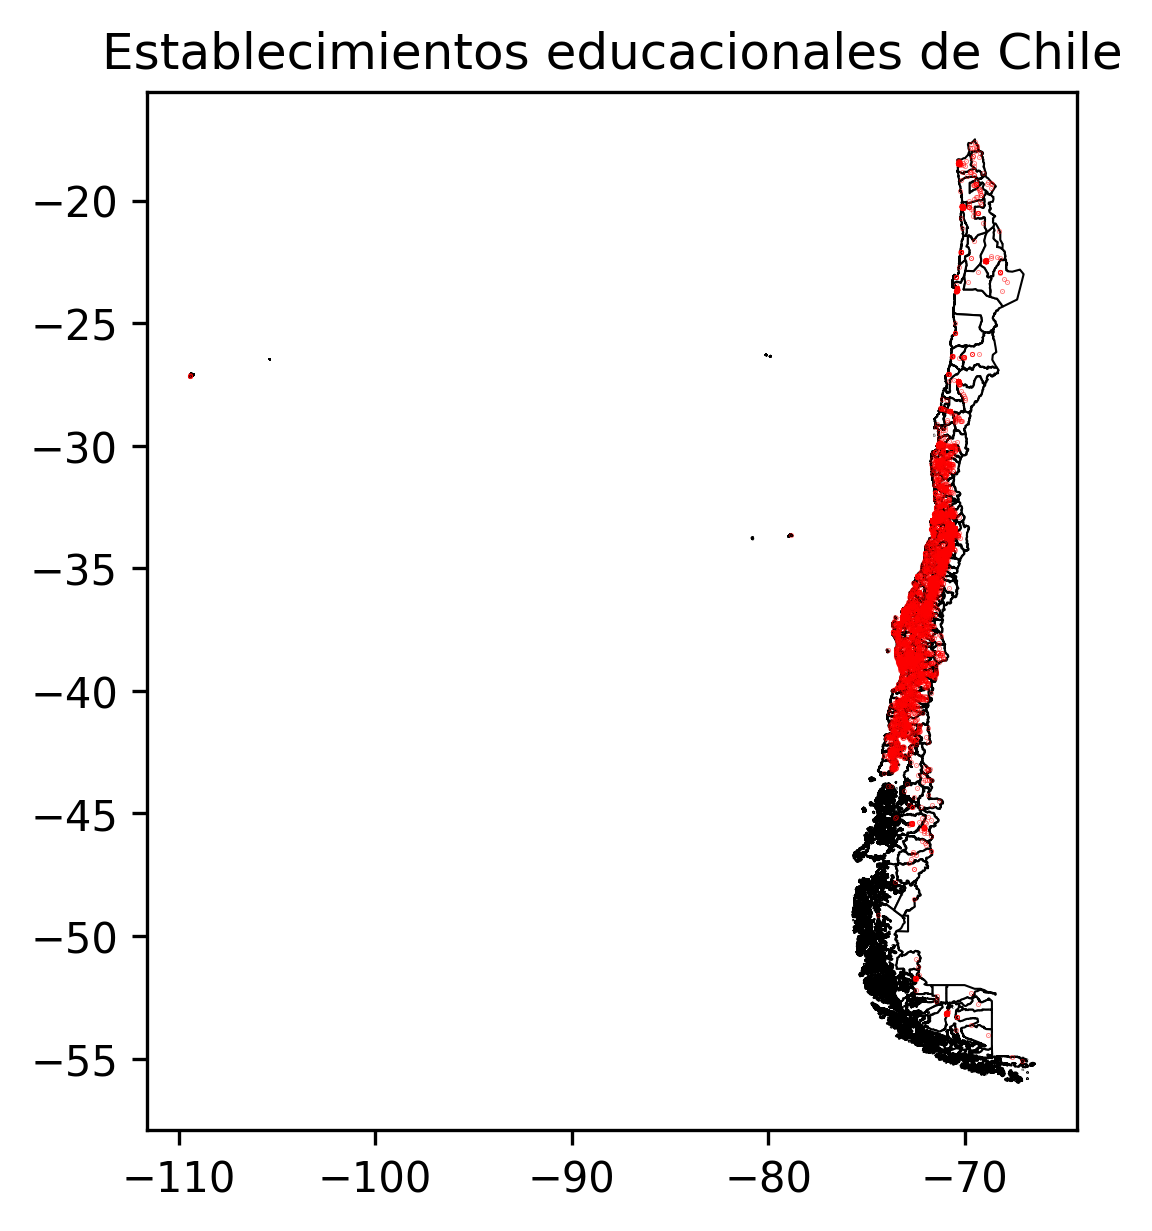

In [35]:
fig, ax = plt.subplots(figsize=(4, 8), dpi=300)
bd4_com.plot(ax=ax, color="red", zorder=2, markersize=0.05, marker="o", alpha=0.5)
gdf_comunas.plot(ax=ax, color="white", linewidth=0.5, zorder=1, edgecolor="black")
ax.set_title("Establecimientos educacionales de Chile")

### 4.2 Conteste las siguientes preguntas usando las bases creadas en los puntos anteriores.

#### a. ¿Cómo son las distribuciones de notas y asistencia para los estudiantes de los establecimientos educacionales chilenos?  (5 puntos) 

Text(0.5, 1.0, 'Histograma de promedios generales')

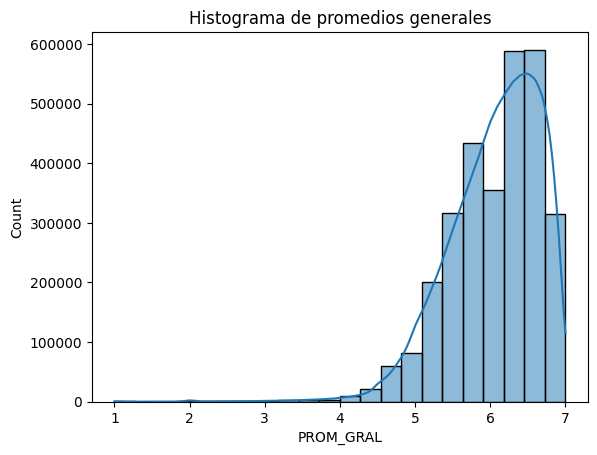

In [36]:
r_sturges = math.log2(len(bd1_clean)) + 1

sns.histplot(data=bd1_clean, x="PROM_GRAL", bins=int(r_sturges), kde=True, kde_kws = {'bw_adjust': 2})
sns.set_style("whitegrid")
plt.title("Histograma de promedios generales")

#### Respuesta pt1:

La distrubucion de las notas de los estudiantes chilenos se trata de una asimetria hacia la izquierda, donde gran parte de las observaciones se concentran cerca del valor maximo (7.0). A la final esto nos dice que gran parte de las notas se concentran entre la mediana (6,2) y el valor maximo(7.0), incluso el promedio de las notas (6,0) esta por debajo de la mediana.

<Figure size 2000x1600 with 0 Axes>

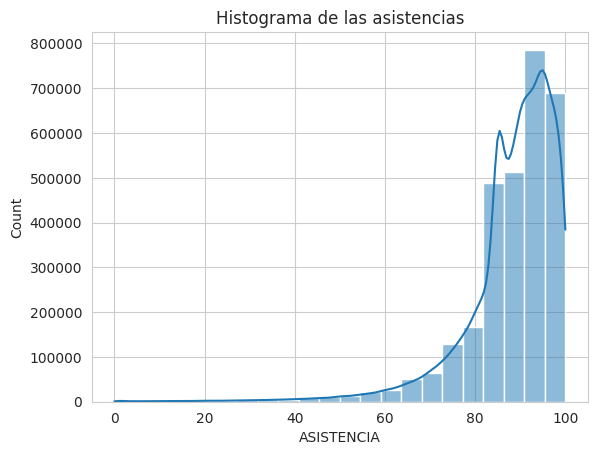

<Figure size 2000x1600 with 0 Axes>

In [37]:
r_sturges = math.log2(len(bd1_clean)) + 1
sns.histplot(data=bd1_clean, x="ASISTENCIA", bins=int(r_sturges), kde=True, kde_kws={'bw_adjust': 2})
sns.set_style("whitegrid")
plt.title("Histograma de las asistencias")
plt.figure(figsize=(5,4), dpi=400)

#### Respuesta pt2:

Al igual que el caso anterior, la distribucion de la asistencia de los estudiantes chilenos se trata de una asimetria hacia la izquierda, donde gran parte de las observaciones se concentran cerca del valor maximo (100). A la final esto nos dice que gran parte de las asistencias se concentran entre la mediana (90) y el valor maximo(100), incluso el promedio de las asistencias (88) esta por debajo de la mediana. 

A la final en ambos casos se tiene que gran parte de los estudiantes en chile poseen un promedio sobre 6,0 o cercano a este mismo, y una asistencia en torno al 88%. Sin embargo a priori no podemos asumir que una alta asistencia implica mejores notas, si no que esto puede depender a otros factores como la calidad de la educacion, la motivacion de los estudiantes, etc. Por lo tanto del analisis podemos deducir que la asistencia no es un factor determinante en el rendimiento escolar de los estudiantes chilenos, por el momento es una coincidencia que la asistencia y el promedio de notas esten en rango cercanos al maximo.

---

#### b. ¿Existe alguna diferencia entre la ASISTENCIA y PROM_GRAL de estudiante de educación media científico-humanista y técnico-profesional?  (10 puntos) 

In [38]:
bd1_mch = bd1_clean[bd1_clean['NIVEL'] == 'media_ch']
bd1_mtp = bd1_clean[bd1_clean['NIVEL'] == 'media_tp']

/tmp/ipykernel_4236/3771858491.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="PROM_GRAL", data=bd1_mch, palette="Set3", width=0.5, ax=axs[0])
/tmp/ipykernel_4236/3771858491.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="PROM_GRAL", data=bd1_mtp, palette="Set3", width=0.5, ax=axs[1])


<Figure size 2000x1600 with 0 Axes>

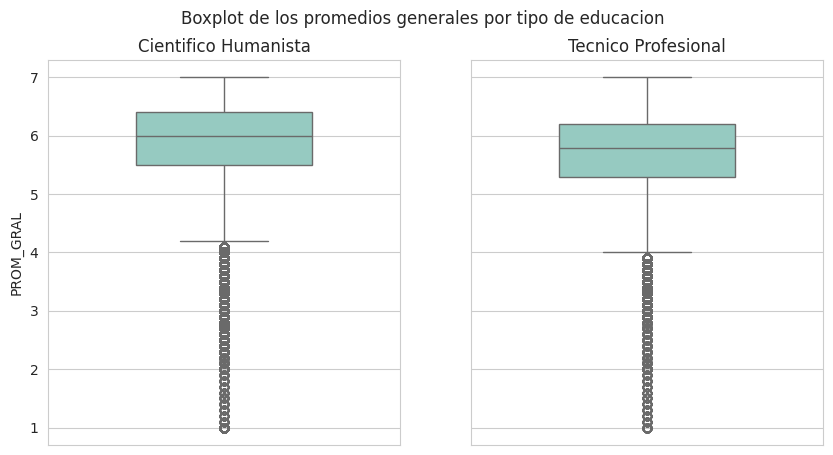

<Figure size 2000x1600 with 0 Axes>

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Boxplot de los promedios generales por tipo de educacion\n \n")
sns.boxplot(y="PROM_GRAL", data=bd1_mch, palette="Set3", width=0.5, ax=axs[0])
axs[0].set(title="Cientifico Humanista")
sns.boxplot(y="PROM_GRAL", data=bd1_mtp, palette="Set3", width=0.5, ax=axs[1])
axs[1].set(title="Tecnico Profesional")
plt.figure(figsize=(5,4), dpi=400, facecolor="white")

#### Respuesta parte 1:

A simple vista notamos que la cajita en ambos graficos son muy similares en longitud, lo que significa que gran parte de los datos (50%) se concentran cerca del intervalo (6,0). Sin embargo los promedios son distintos, ya que el cientifico humanista tiene un promedio de notas 6,0 y el tecnico profesional un 5,6, ademas en ambos graficos de caja notamos una gran cantidad de datos atipicos, pero bajo el contexto educativo son datos de los estudiantes que reprobaron el año escolar. 

Pese a lo anterior, ambos tipos de educacion poseen una tendencia muy similar donde gran parte de los datos se concentran en el intervalo (5,0 - 6,0), por lo que podemos decir que no existe una diferencia significativa entre el promedio general de notas de los estudiantes de educacion media cientifico humanista y tecnico profesional.

Sin embargo el intervalo C3-MAX del cientifico humanista tiene una menor dispersion que el intervalo de C3-MAX del tecnico profesional.

/tmp/ipykernel_4236/1016515291.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="ASISTENCIA", data=bd1_mch, palette="Set3", width=0.5, ax=axs[0])
/tmp/ipykernel_4236/1016515291.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="ASISTENCIA", data=bd1_mtp, palette="Set3", width=0.5, ax=axs[1])


<Figure size 2000x1600 with 0 Axes>

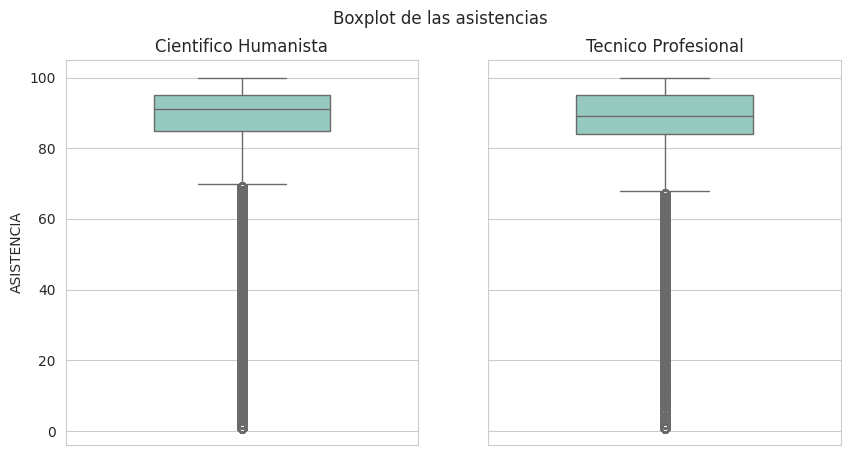

<Figure size 2000x1600 with 0 Axes>

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Boxplot de las asistencias\n")
sns.boxplot(y="ASISTENCIA", data=bd1_mch, palette="Set3", width=0.5, ax=axs[0])
axs[0].set(title="Cientifico Humanista")
sns.boxplot(y="ASISTENCIA", data=bd1_mtp, palette="Set3", width=0.5, ax=axs[1])
axs[1].set(title="Tecnico Profesional")
plt.figure(figsize=(5,4), dpi=400, facecolor="white")

#### Respuesta parte 2:

A simple vista en ambos graficos, al menos el 75% de los datos se ubican sobre el 80% de asistencia, y entre MIN-C1 los datos son super dispersos y en el C3-MAX los datos no estan muy dispersos. Sin embargo, notamos que los bigotes en ambos graficos son muy diferentes, ya que la mediana (C2) de los datos en el cientifico-humanista es mayor que en el tecnico-profesional.

Finalmente podemos decir que en temas de promedio de notas, estan muy parecidos (no es una diferencia significatoria), ya que ambos se concentran entre el intervalo de (5,0 - 6,0), pero cuando nos aceramos al 7, la dispersion de las notas aumenta gradualmente en el caso del tecnico profesional y en el caso del cientifico humanista no ocurre de forma tan marcada. Pese a lo anterior se puede afirmar que el cientifico humanista posee un promedio de notas mayor que el tecnico profesional (viendo la mediana).

En temas de asistencia, el cientifico humanista posee una asistencia mayor que el tecnico profesional, ya que la mediana (C2) del cientifico humanista es mayor que la del tecnico profesional. Sin embargo, en ambos casos la asistencia es muy alta, ya que gran parte de los datos se concentran sobre el 80% de asistencia. 


---

#### c. ¿Cómo varía la ASISTENCIA de los estudiantes de acuerdo a su edad? ¿Hay algún patrón detectable?  (10 puntos) 

In [41]:
bd1_gb = bd1_clean.groupby("EDAD_ALU").agg({"ASISTENCIA": "mean"}).reset_index()

In [42]:
bd1_gb

,EDAD_ALU,ASISTENCIA
0,3,93.000000
1,5,87.106383
2,6,86.025807
3,7,86.879007
4,8,87.561471
5,9,88.250015
6,10,88.698089
7,11,89.197650
8,12,89.433198
9,13,89.490102


<Axes: title={'center': 'Asistencia promedio por edad'}, xlabel='Edad', ylabel='Asistencia'>

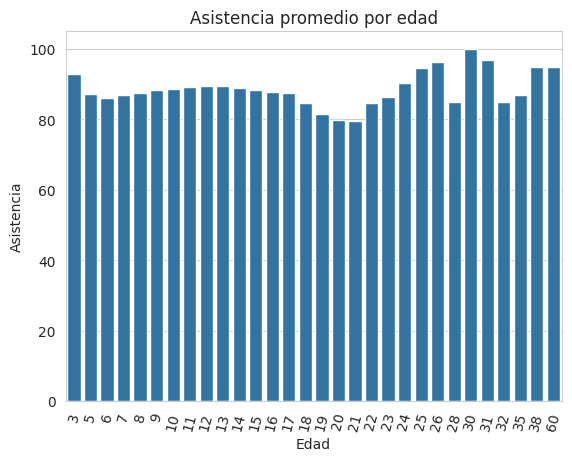

In [43]:
plt.title("Asistencia promedio por edad")
plt.xticks(rotation=75)
plt.xlabel("Edad")
plt.ylabel("Asistencia")
sns.barplot(data=bd1_gb, x="EDAD_ALU", y="ASISTENCIA")


Notemos que existen algunas edades que estan en un intervalo que no corresponde, esto de puede deber a que existen establecimientos que imparten varios tipos de educacion a la vez y entre eso, esos datos se colaron.

<Axes: ylabel='EDAD_ALU'>

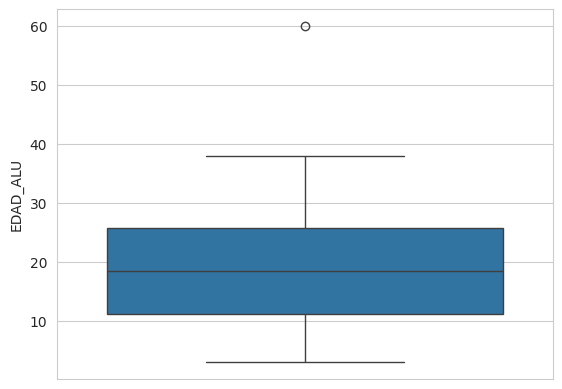

In [44]:
sns.boxplot(data=bd1_gb, y = "EDAD_ALU")

In [45]:
bd1_gb.describe()

,EDAD_ALU,ASISTENCIA
count,30.000000,30.000000
mean,19.933333,88.650726
std,12.031377,4.888899
min,3.000000,79.455882
25%,11.250000,86.102689
50%,18.500000,87.948043
75%,25.750000,90.039192
max,60.000000,100.000000


Con el boxplot anterior podemos notar que existen edades outlier, por lo que bastara filtrar hasta EDAD_ALU = 25

<Axes: xlabel='EDAD_ALU', ylabel='ASISTENCIA'>

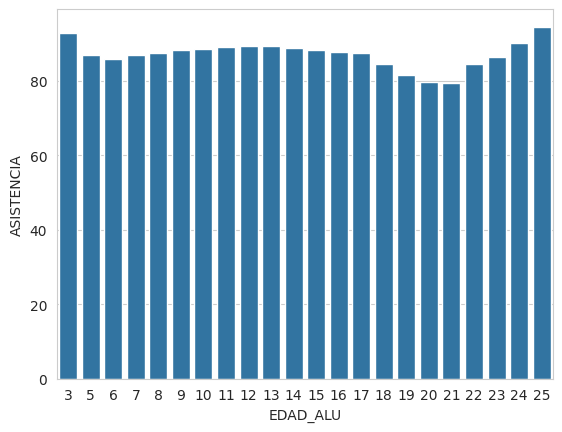

In [46]:
sns.barplot(data=bd1_gb[bd1_gb["EDAD_ALU"] <= 25], x="EDAD_ALU", y="ASISTENCIA")

Al realizar el grafico de barras notamos que existe una bajada de asistencia desde los 13-14 años hasta los 20 años, quizas esto se pueda deber a que los estudiantes entran a la adolesencia y son mas desprocupados, aunque no se puede asumir nada sin tener una variable categorica o mas informacion, por lo que no podemos concluir nada hasta el momento a priori

Por lo tanto, no se puede establecer ningun patron detectable debido que necesitamos mas informacion para estimar que esta sucediento al momento de que los alumnos cumplen 13-14 años y su asistencia empieza a disminuir hasta los 20 años, quizas pueda ser lo anterior mencionado, pero con tan poca informacion es irresponsable dar un veredicto.

#### d. ¿Son consistentes los datos la situación final de cada estudiante con sus datos de ASISTENCIA y PROM_GRAL? ¿Puede identificar alguna anomalía en los datos? (10 puntos)

En caso que su respuesta sea afirmativa, proponga cómo tratar dichos datos anómalos.

### En primera instancia se va analizar la situacion en donde el estudiante reprueba el año escolar.

/tmp/ipykernel_4236/2961163572.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="PROM_GRAL", data=bd1_clean[bd1_clean["SIT_FINAL"] == "R"], palette="Set3", width=0.5)


Text(0.5, 1.0, 'Boxplot de las asistencias de los reprobados')

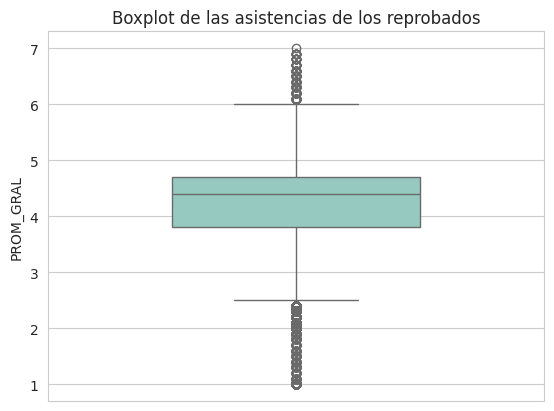

In [47]:
sns.boxplot(y="PROM_GRAL", data=bd1_clean[bd1_clean["SIT_FINAL"] == "R"], palette="Set3", width=0.5)
plt.title("Boxplot de las asistencias de los reprobados")



#### Respuesta parte 1:

Al realizar el boxplot sobre la situacion final de los estudiantes reprobados notamos que existe un numero importante de datos (75%) que son cercanos o mayores a 4.0, lo cual viene siendo atipico cuando la nota de aprobacion es 4.0 y cuando tambien tenemos datos outliner que estan cercanos al 7.0. Sin embargo, no podemos concluir nada al respecto, ya que debemos ver la asistencia de los alumnos para ver si este puede ser un factor de la grafica.

/tmp/ipykernel_4236/383378534.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="ASISTENCIA", data=bd1_clean[bd1_clean["SIT_FINAL"] == "R"], palette="Set3", width=0.5)


Text(0.5, 1.0, 'Boxplot de las asistencias de los reprobados')

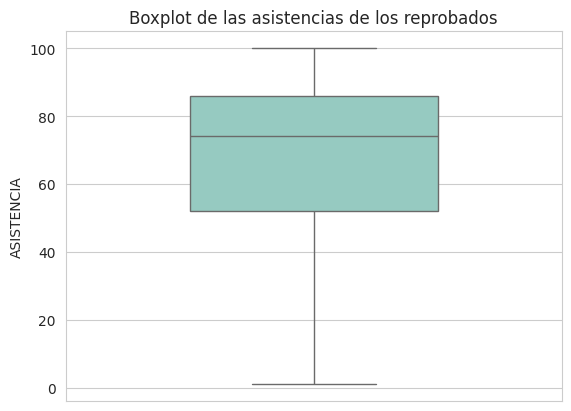

In [48]:
sns.boxplot(y="ASISTENCIA", data=bd1_clean[bd1_clean["SIT_FINAL"] == "R"], palette="Set3", width=0.5)
plt.title("Boxplot de las asistencias de los reprobados")

In [49]:
bd1_clean[bd1_clean["SIT_FINAL"] == "R"]["ASISTENCIA"].describe()

count    51766.000000
mean        66.792315
std         24.887795
min          1.000000
25%         52.000000
50%         74.000000
75%         86.000000
max        100.000000
Name: ASISTENCIA, dtype: float64

#### Respuesta parte 2:

Al analizar el boxplot notamos que el C3 (75%) es igual a 86% de asistencia, lo que quiere decir que aproximadamente un 75% de los estudiantes de chile reprueba el año escolar por tener una asistencia menor al 85% o por no cumplir con la nota de aprobacion (4.0). 

Sin embargo, tenemos otro 25% de los estudiantes que cumplen con el requisito de obtener una asistencia mayor al 85%, pero estos terminan reprobando porque poseen dos ramos con calificacion menor a 4.0 y poseer un promedio de todos los ramos menor a 5.0 (Decreto Supremo Nº 67). Para comprobar que esto pasa en verdad, se realizara el grafico que contiene los estudiantes con asistencia mayor o igual al 85%, pero que no aprobaron.

/tmp/ipykernel_4236/3676931571.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="PROM_GRAL", data=bd1_r, palette="Set3", width=0.5)


<Axes: title={'center': 'Boxplot de los reprobados con asistencia mayor a 85%'}, ylabel='PROM_GRAL'>

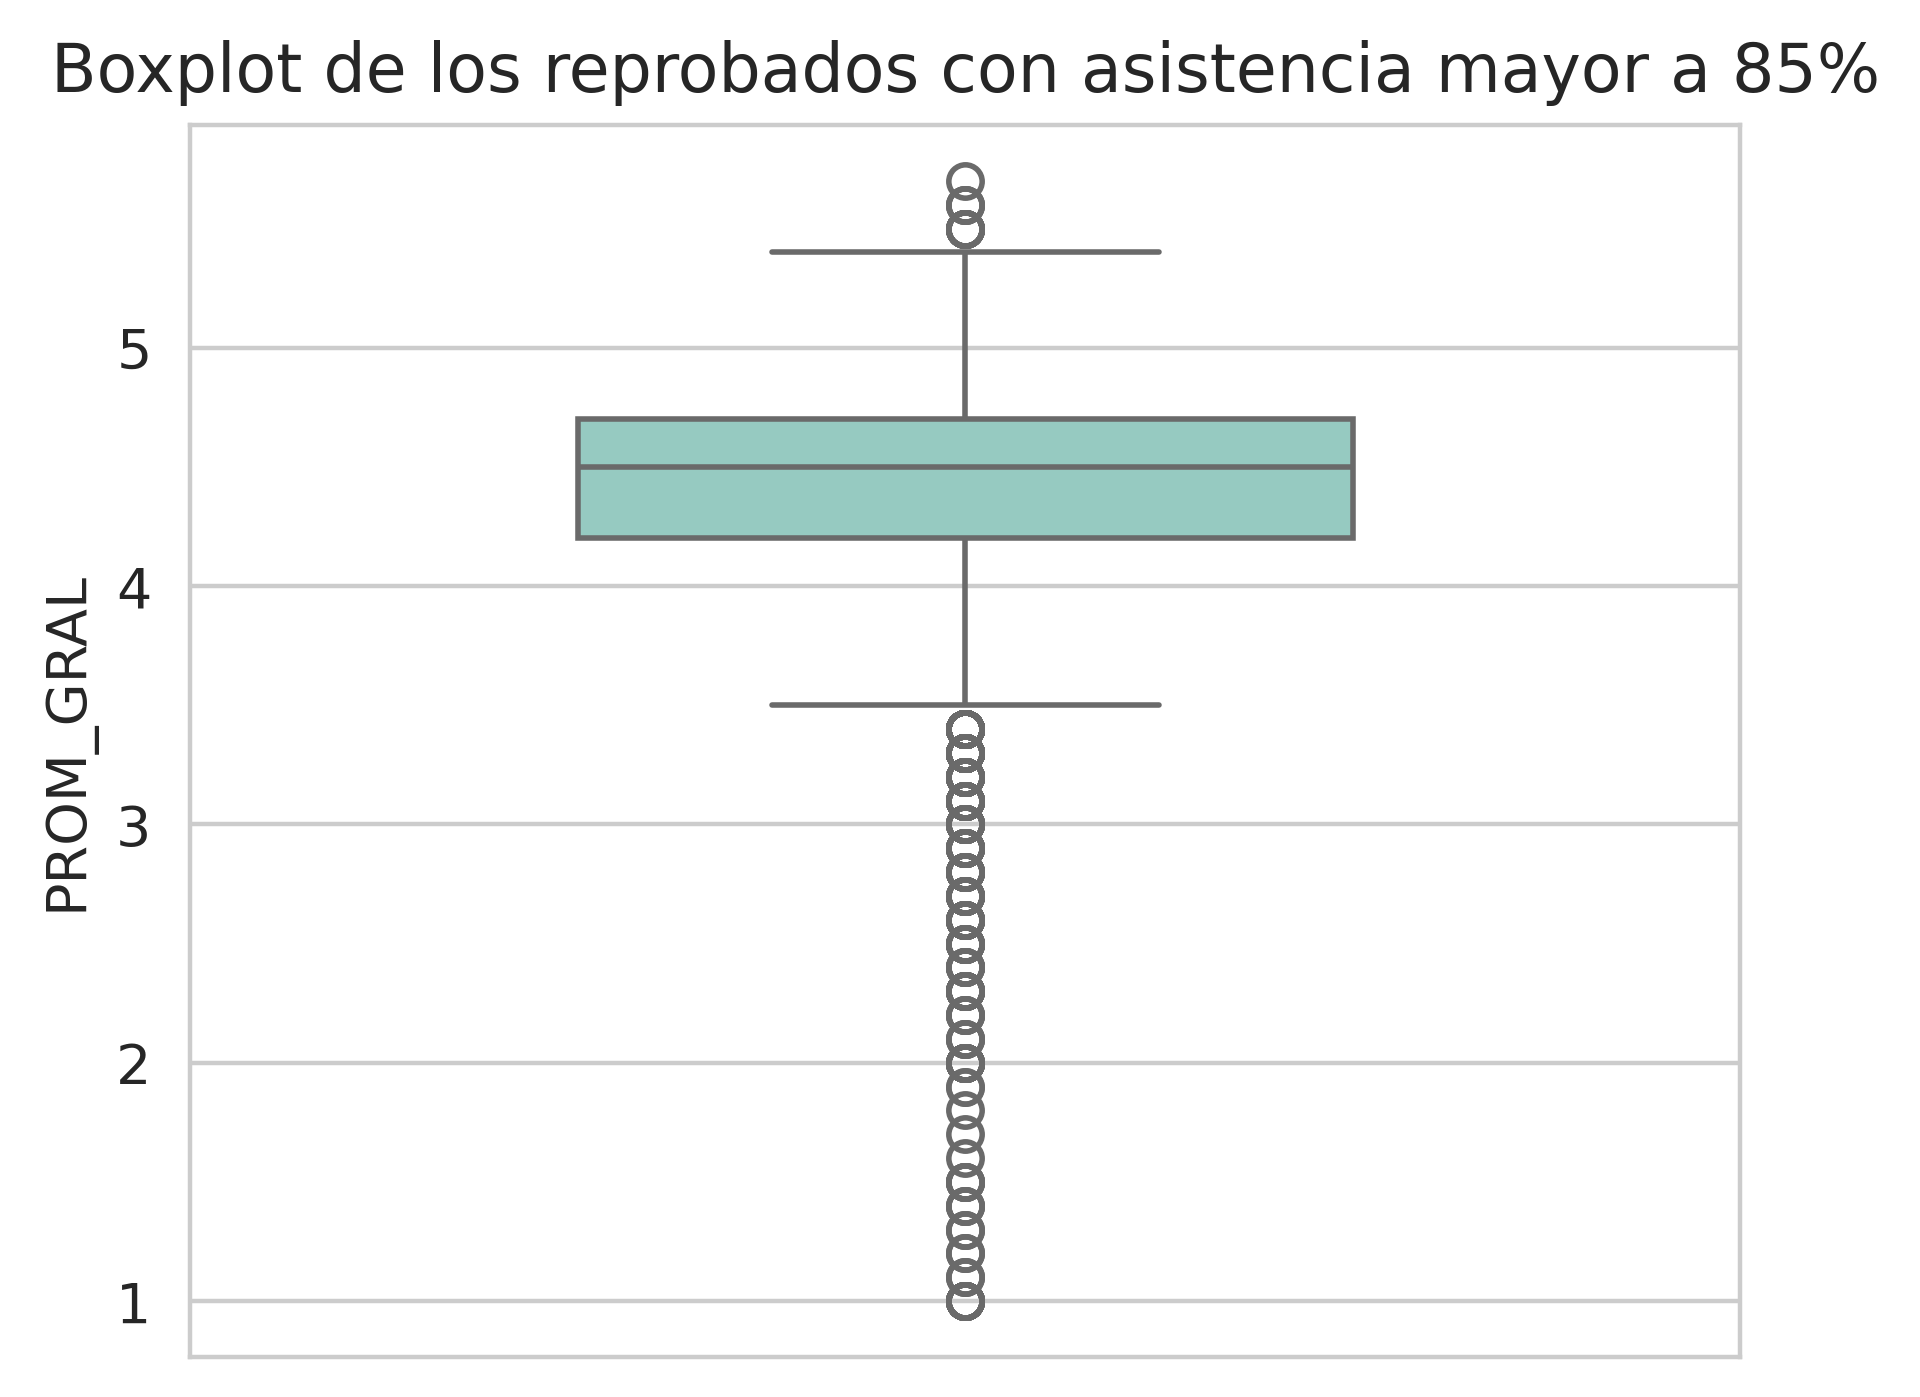

In [50]:
bd1_r = bd1_clean.loc[(bd1_clean["SIT_FINAL"] == "R") & (bd1_clean["ASISTENCIA"] > 85)]
plt.figure(figsize=(5,4), dpi=400, facecolor="white")
plt.title("Boxplot de los reprobados con asistencia mayor a 85%")
sns.boxplot(y="PROM_GRAL", data=bd1_r, palette="Set3", width=0.5)


#### Respuesta parte 3:

El boxplot anterior nos indica que gran parte (75% aprox) de los estudiantes que cumplen con el requisito de asistencia, pero que no aprueban el año escolar, es porque poseen una nota menor a 5.0 con dos ramos reprobados. Sin embargo, existen otros casos particulares que cumplen con toda las normativas segun el decreto supremo Nº 67, pero que aun asi no aprueban el año escolar, quizas esto se pueda deber a algun motivo de fuerza mayor, pero no se puede concluir nada al respecto.

Finalmente podemos decir que los datos en los estudiantes reprobados estan correctos o son consistentes, debido que gran parte de ellos reprueban por no cumplir la normativa del decreto supremo Nº 67, y el resto de los casos son casos particulares que no se pueden concluir nada al respecto. Sin embargo, para facilitar el futuro analisis de la base de datos, se deberia agregar una variable categorica que represente o generalize los casos en donde el estudiante repueba a pesar de que cumpla los requisitos de aprobacion.

### En segunda instancia vereamos la situacion en donde el estudiante aprueba el año escolar.

/tmp/ipykernel_4236/2290124123.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="PROM_GRAL", data=bd1_clean[bd1_clean["SIT_FINAL"] == "P"], palette="Set3", width=0.5)


Text(0.5, 1.0, 'Boxplot de los aprobados')

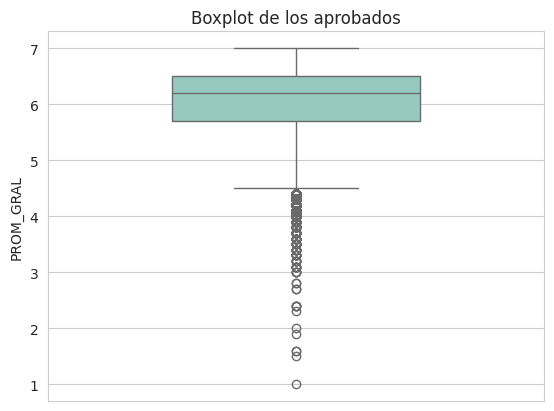

In [51]:
sns.boxplot(y="PROM_GRAL", data=bd1_clean[bd1_clean["SIT_FINAL"] == "P"], palette="Set3", width=0.5)
plt.title("Boxplot de los aprobados")

/tmp/ipykernel_4236/216312202.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="ASISTENCIA", data=bd1_clean[bd1_clean["SIT_FINAL"] == "P"], palette="Set3", width=0.5)


Text(0.5, 1.0, 'Boxplot de las asistencias de los aprobados')

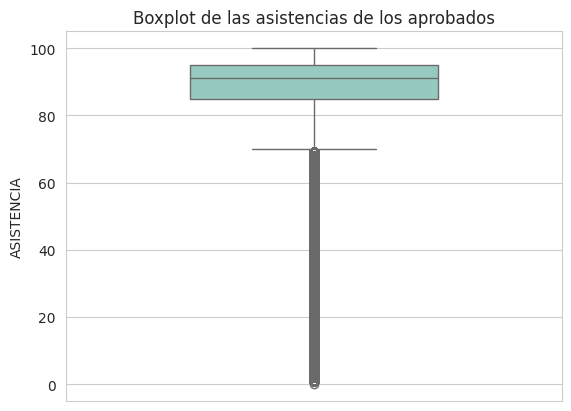

In [52]:
sns.boxplot(y="ASISTENCIA", data=bd1_clean[bd1_clean["SIT_FINAL"] == "P"], palette="Set3", width=0.5)
plt.title("Boxplot de las asistencias de los aprobados")

Apartir de los graficos anteriores podemos decir que gran parte de las observaciones son consistentes, aunque observamos algunos puntos que son outliners, pero estos no representan un gran porcentaje de los datos y pueden ser tratados, pero de todas formas los vamos analizar.

---

#### Analisis de las observacions que son outliners en el caso de los estudiantes aprobados.

Se va analizar el caso en donde el estudiante aprueba apesar de que no cumple ni con el promedio minimo de notas y el porcentaje de asistencia mayor o igual al 85%.

In [53]:
data = bd1_clean.loc[(bd1_clean["SIT_FINAL"] == "P") & (bd1_clean["PROM_GRAL"] < 4) & (bd1_clean["ASISTENCIA"] < 85)]
data

,COD_COMUNA,NIVEL,EDAD_ALU,PROM_GRAL,ASISTENCIA,SIT_FINAL
17230,15101,media_ch,16,3.9,80,P
17360,1101,media_ch,18,3.7,80,P
34290,1101,basica,9,3.3,4,P
134960,3101,basica,15,3.0,17,P
175276,4102,media_ch,19,3.9,80,P
...,...,...,...,...,...,...
2987234,13112,basica,14,3.5,65,P
3062798,13401,basica,13,3.9,65,P
3135963,13404,media_ch,14,3.0,68,P
3313657,13603,basica,14,3.9,60,P


Text(0.5, 1.0, 'Boxplot de los aprobados con promedio menor a 4.0')

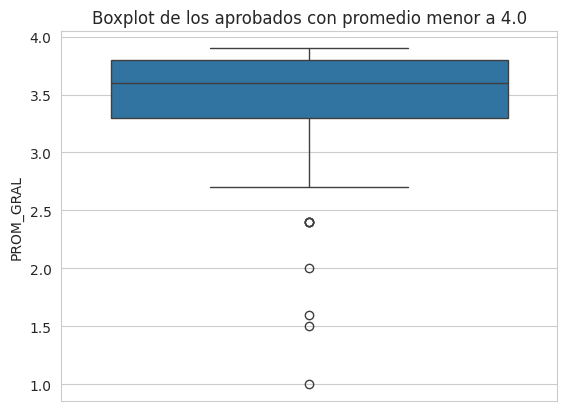

In [54]:
sns.boxplot(data= data, y="PROM_GRAL")
plt.title("Boxplot de los aprobados con promedio menor a 4.0")

Text(0.5, 1.0, 'Boxplot de las asistencias de los aprobados con promedio menor 4.0')

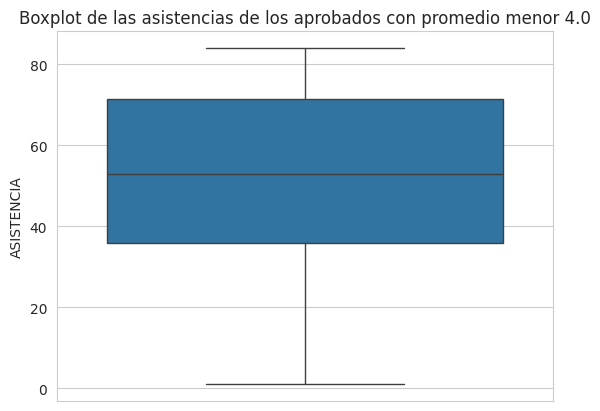

In [55]:
sns.boxplot(data=data, y = "ASISTENCIA")
plt.title("Boxplot de las asistencias de los aprobados con promedio menor 4.0")

Con los graficos anterior podemos ver que existen 119 casos de alumnos que aprueban sin cumplir ninguno de los requisitos academicos impuestos por el decreto supremo Nº 67.

#### Respuesta parte 4:

A la final gran parte de las observaciones son consistentes, pero existen bastantes casos particulares que requieren de mayor informacion para su analisis, por lo que se deberia agregar una variable categorica que represente o generalize los casos en donde el estudiante aprueba a pesar de que no cumpla los requisitos de aprobacion o de porque aprobo apesar de no cumplir los requisitos que impone el decreto supremo Nº 67.


Esta variable categorica es importante para determinar los alumnos que reprueban apesar de cumplir las condiciones para aprobar, ya que puede existir el caso de que haya reprobado por motivo de los padres, aunque ese analisis no puede ser certero por falta de informacion, al igual del caso de los alumnos que aprueban apesar de no cumplir no anterior mencionado.


#### e. ¿Cómo varía la tasa de docentes/estudiantes por región y por tipo de educación? ¿Hay algún patrón detectable? (10 puntos)

In [56]:
bd23_gb = bd2_3_clean.groupby(["REGION", "TIP_EDUCACION"]).agg({"RAZON_DOC_EST": "mean", "DC_TOT": "mean", "MAT_TOTAL": "mean"}).reset_index()

In [57]:

bd23_gb


,REGION,TIP_EDUCACION,RAZON_DOC_EST,DC_TOT,MAT_TOTAL
0,1,1,0.204746,25.500000,340.957143
1,1,2,0.064285,24.324561,488.517544
2,1,3,0.139336,15.882353,230.764706
3,1,4,0.048474,27.000000,557.000000
4,2,1,0.111346,38.352000,588.872000
...,...,...,...,...,...
61,15,5,0.455276,26.396825,293.539683
62,16,1,0.280046,20.703971,155.985560
63,16,2,0.085664,30.169355,422.411290
64,16,3,0.085581,21.500000,282.750000


<Axes: xlabel='REGION', ylabel='RAZON_DOC_EST'>

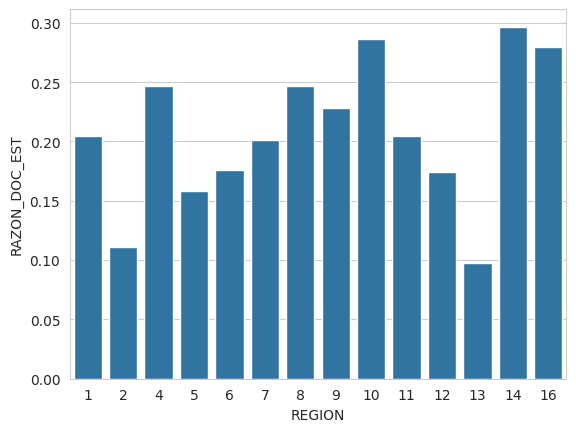

In [58]:
sns.barplot(data=bd23_gb[bd23_gb["TIP_EDUCACION"] == 1], x="REGION", y="RAZON_DOC_EST")

<Axes: xlabel='REGION', ylabel='RAZON_DOC_EST'>

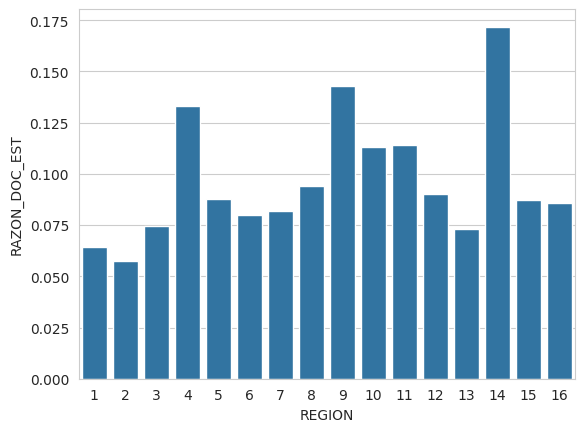

In [59]:
sns.barplot(data=bd23_gb[bd23_gb["TIP_EDUCACION"] == 2], x="REGION", y="RAZON_DOC_EST")

<Axes: xlabel='REGION', ylabel='RAZON_DOC_EST'>

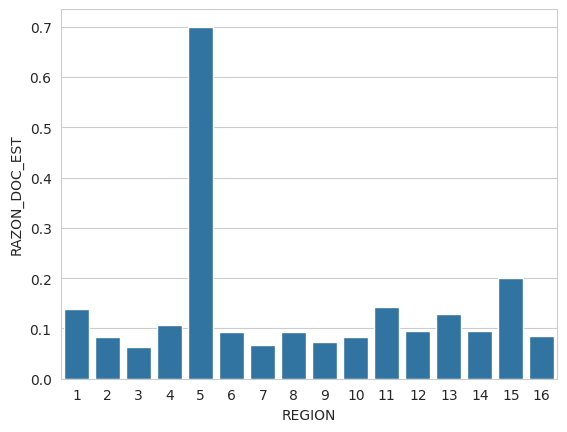

In [60]:
sns.barplot(data=bd23_gb[bd23_gb["TIP_EDUCACION"] == 3], x="REGION", y="RAZON_DOC_EST")

<Axes: xlabel='REGION', ylabel='RAZON_DOC_EST'>

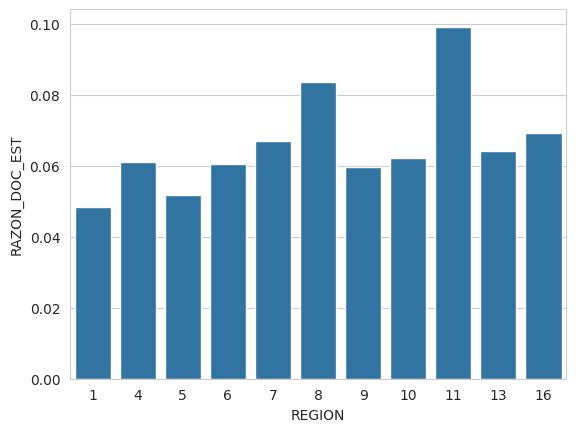

In [61]:
sns.barplot(data=bd23_gb[bd23_gb["TIP_EDUCACION"] == 4], x="REGION", y="RAZON_DOC_EST")

<Axes: xlabel='REGION', ylabel='RAZON_DOC_EST'>

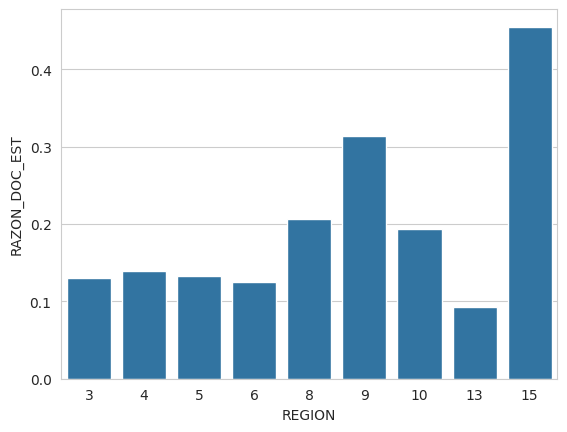

In [62]:
sns.barplot(data=bd23_gb[bd23_gb["TIP_EDUCACION"] == 5], x="REGION", y="RAZON_DOC_EST")

#### f. ¿Puede identificar alguna correlación entre el rendimiento escolar (PROM_GRAL), la ASISTENCIA, y la RAZON_DOC_EST para los escolares chileno (no-adultos)? ¿Cree que es posible realizar este análisis, y plantear algún modelo (general o parcial) a partir de los datos utilizados? (15 puntos)

Justifique y argumente claramente su respuesta.

Text(0.5, 1.0, 'Correlacion de Spearman')

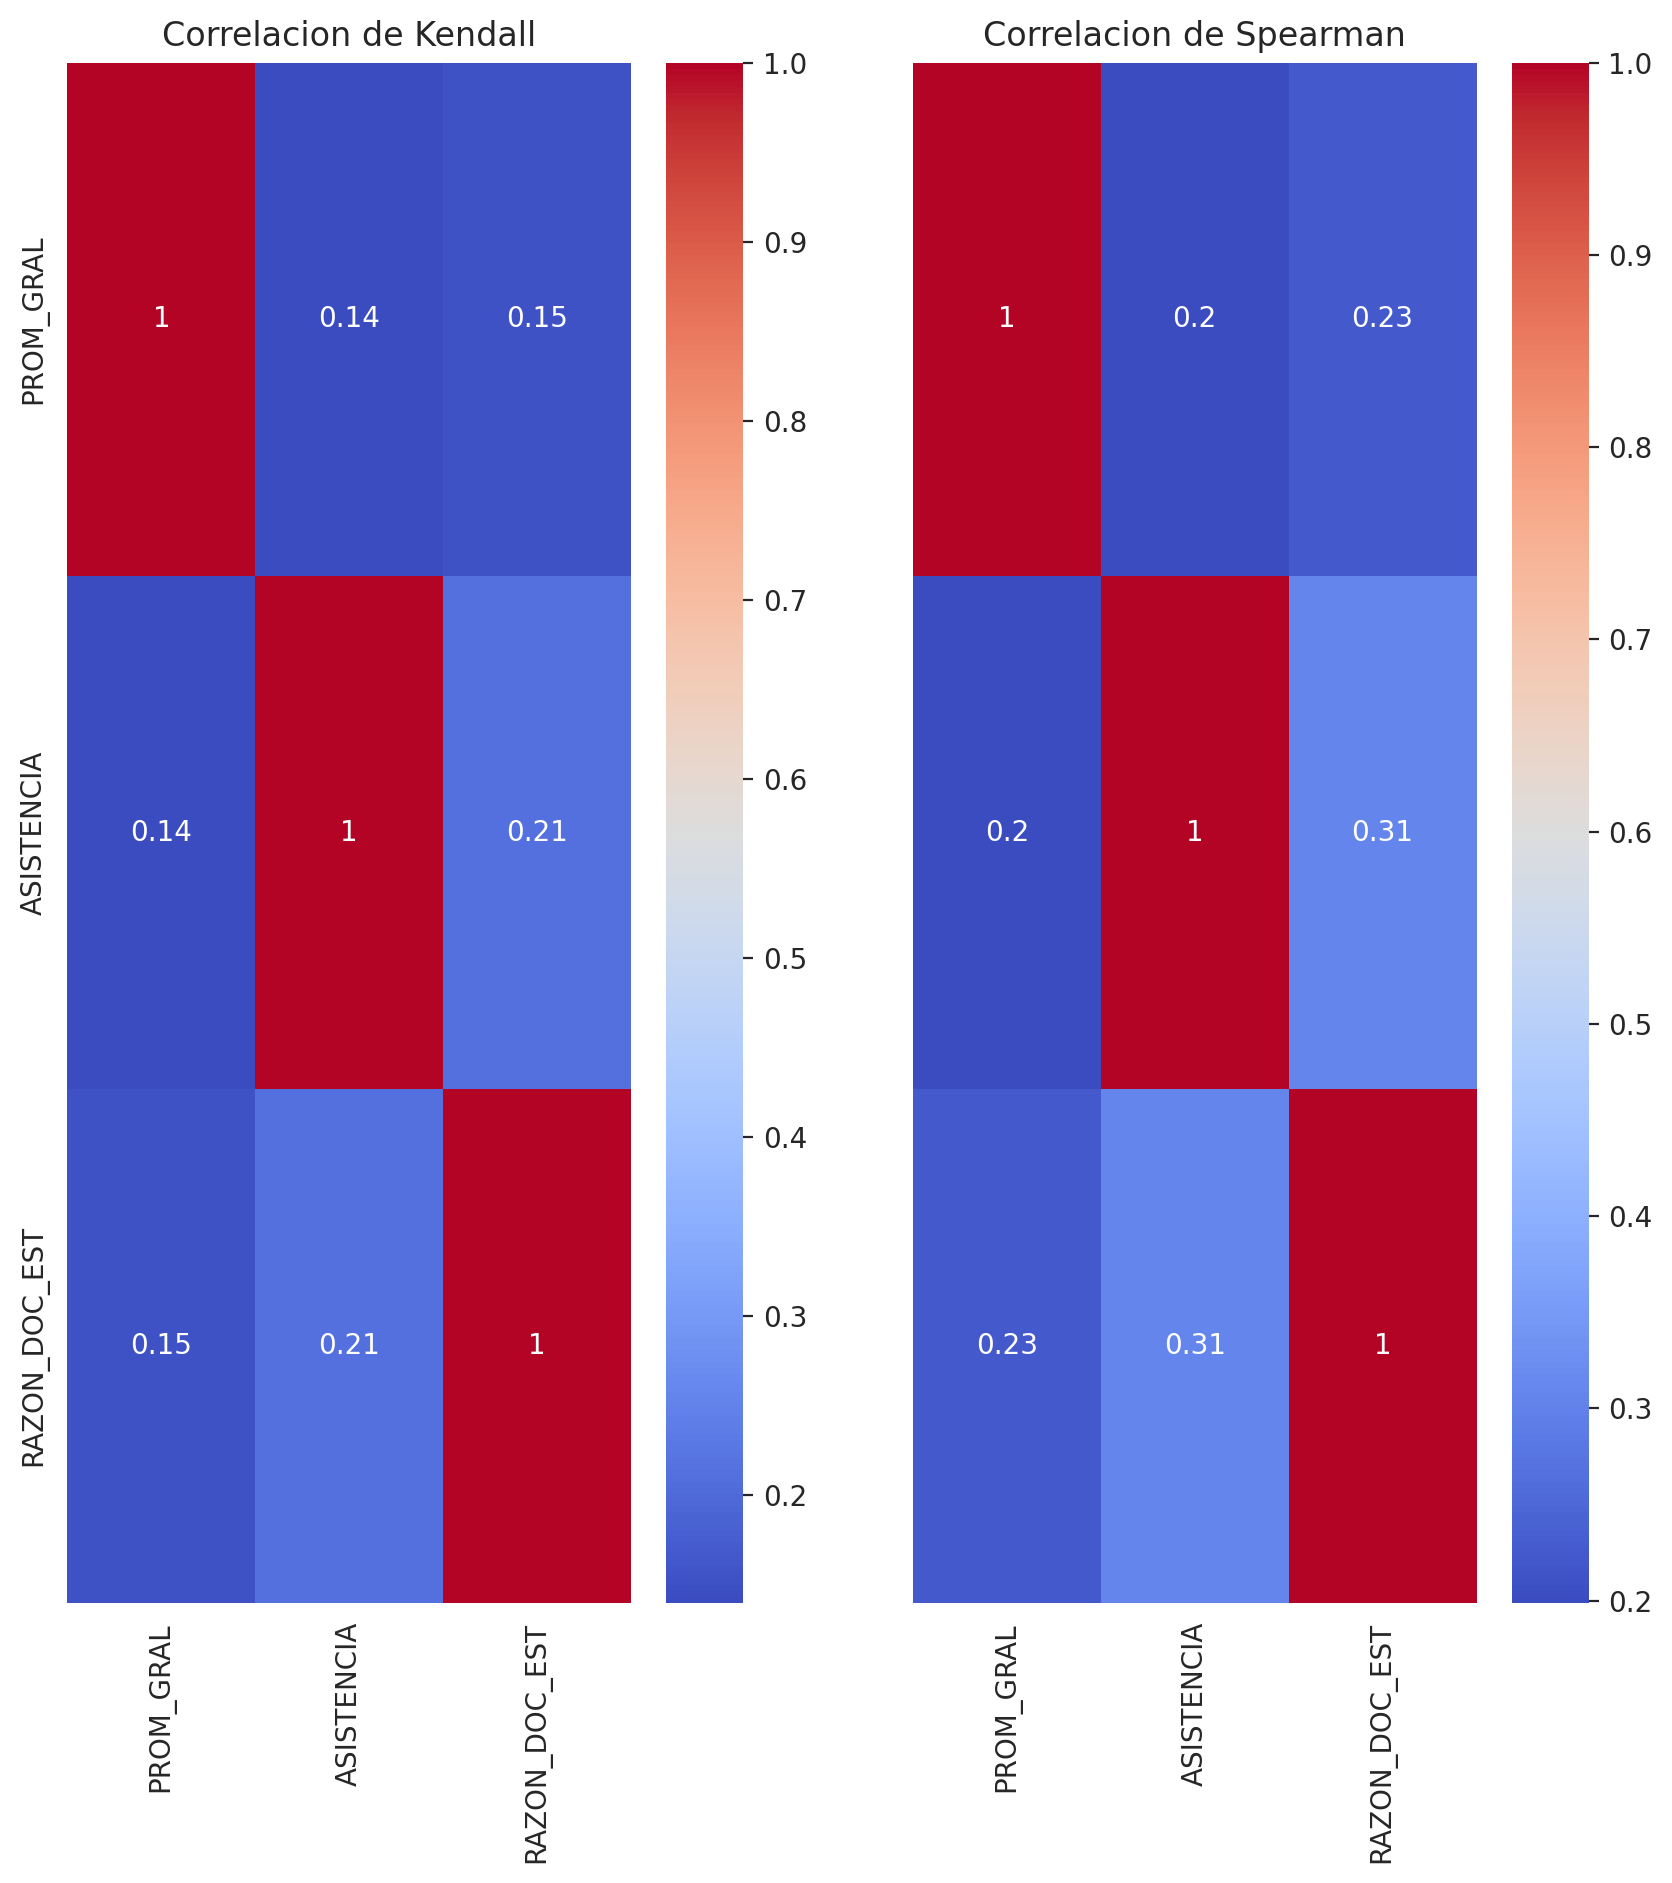

In [64]:
corr_matrix = lambda x : df_com[["PROM_GRAL", "ASISTENCIA", "RAZON_DOC_EST"]].corr(method=x)
fig, ax = plt.subplots(figsize=(10,10), dpi=200, ncols=2, sharey=True, sharex=True)

sns.heatmap(corr_matrix("kendall"), annot=True, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Correlacion de Kendall")
sns.heatmap(corr_matrix("spearman"), annot=True, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Correlacion de Spearman")


<Axes: title={'center': 'Matriz de correlacion de Pearson'}>

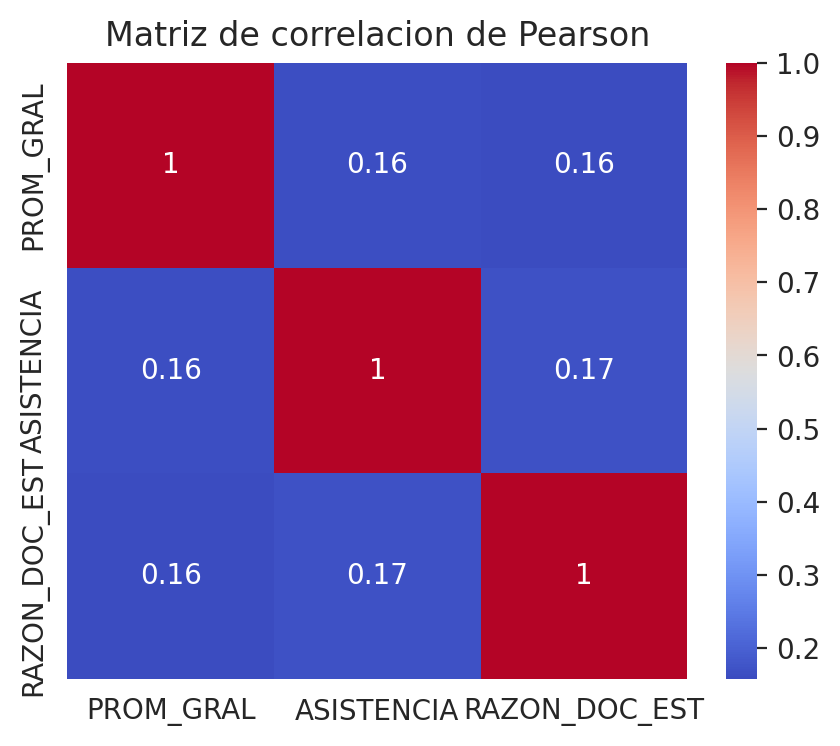

In [65]:
plt.figure(figsize=(5,4), dpi=200, facecolor="white")
plt.title("Matriz de correlacion de Pearson")
sns.heatmap(data=corr_matrix("pearson"), annot=True, cmap="coolwarm")


Al realizar 3 tipos de correlaciones (kendall, pearson y spearman) notamos que la correlacion entre las variables sigue siendo baja, ya que un valor que nos daria una correlacion debe estar en torno a 0,7 y 1.

Al usar una matriz de correlacion podemos notar que existe una relacion entre las variables, sin embargo la correlacion al ver el mapa de calor es un tono azul, lo que indica que la correlacion entre las 3 variables es baja, ya que para que exista al menos una correlacion buena entre los datos esta deberia estar en torno a 0,7 a 1.

Debido a lo anterior, no podemos plantear a priori un modelo que nos ayude analizar los datos y por ello al menos con las herramientas que tenemos no podemos realizar el analisis.